In [1]:
import pandas as pd #載入套件
import numpy as np
df = pd.read_csv("D:\我的文件\Desktop\預測資料\預測資料\住宅大樓\士林區_住宅大樓.csv")#讀檔
df.isna().sum()  #查看nan的值有幾個

date    1
avg     1
max     0
min     0
dtype: int64

In [2]:
df.set_index(['date'], inplace=True) #將日期設為index
df

,avg,max,min
date,,,
2013/1/1,766258.0,766258,766258
2013/1/8,783366.0,783366,783366
2013/1/15,514462.0,514462,514462
2013/1/17,639613.0,639613,639613
2013/1/18,712707.0,875802,504313
...,...,...,...
2021/12/28,366323.0,560598,96543
2021/12/29,505483.0,561983,448984
2021/12/30,511602.0,511602,511602


In [3]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler() 
df=pd.DataFrame(scaler.fit_transform(df), columns=df.columns) #正規化
train = df[0:2500] #訓練集
test = df[2500:]  #測試集

In [4]:
#製造訓練集X Y
import tqdm
n = 30 #用30天資料預測下一筆資料
feature_names = list(train.drop('avg', axis=1).columns)
X = []
y = []
indexes = []
norm_data_x = train[feature_names]
for i in tqdm.tqdm_notebook(range(0,len(train)-n)): 
  X.append(norm_data_x.iloc[i:i+n]. values) 
  y.append(train['avg'].iloc[i+n]) 
  indexes.append(train.index[i+n]) 

<ipython-input-4-1d2d17a4f8aa>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm.tqdm_notebook(range(0,len(train)-n)):


  0%|          | 0/2470 [00:00<?, ?it/s]

In [5]:
#查看資料形狀
X=np.array(X) 
y=np.array(y)
print(X.shape)
print(y.shape)

(2470, 30, 2)
(2470,)


In [6]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
def lstm_model(input_length, input_dim): #建立模型

    
    d=0.3
    model= Sequential() #設定為序列式模型
    model.add(LSTM(64,input_shape=(input_length, input_dim),return_sequences=True)) #input_length表幾步，input_dim表幾個特徵
    model.add(Dropout(d))

    model.add(LSTM(32,input_shape=(input_length, input_dim),return_sequences=False))
    model.add(Dropout(d))
    
    model.add(Dense(1,activation='linear')) #輸入Dense資料
    model.compile(loss='mse',optimizer='adam') #使用的損失函數為 mse  優化函數為adam
    return model

In [7]:
model=lstm_model(30, 2) #建立模型

In [8]:
#%%
history = model.fit(X,y,batch_size=16,epochs=700) ##開始訓練 並自行設定 epochs 跟 batch_size

Epoch 1/700
155/155 [==============================] - 5s 15ms/step - loss: 0.0166
Epoch 2/700
155/155 [==============================] - 3s 17ms/step - loss: 0.0131
Epoch 3/700
155/155 [==============================] - 3s 21ms/step - loss: 0.0129
Epoch 4/700
155/155 [==============================] - 3s 18ms/step - loss: 0.0127
Epoch 5/700
155/155 [==============================] - 3s 21ms/step - loss: 0.0124
Epoch 6/700
155/155 [==============================] - 3s 22ms/step - loss: 0.0119
Epoch 7/700
155/155 [==============================] - 3s 20ms/step - loss: 0.0120
Epoch 8/700
155/155 [==============================] - 3s 22ms/step - loss: 0.0120
Epoch 9/700
155/155 [==============================] - 4s 25ms/step - loss: 0.0117
Epoch 10/700
155/155 [==============================] - 3s 22ms/step - loss: 0.0115
Epoch 11/700
155/155 [==============================] - 3s 21ms/step - loss: 0.0115
Epoch 12/700
155/155 [==============================] - 3s 21ms/step - loss: 0.0115
E

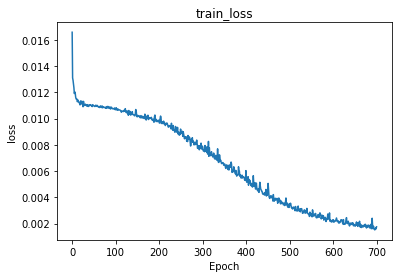

In [9]:
#訓練圖形，可看出loss有下降
import matplotlib.pyplot as plt
plt.title('train_loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.plot(history.history["loss"])

In [10]:
#製造測試集X Y
import tqdm
n = 30 #用30天資料預測下一筆資料
feature_names = list(test.drop('avg', axis=1).columns)
X = []
y = []
indexes = []
norm_data_x = test[feature_names]
for i in tqdm.tqdm_notebook(range(0,len(test)-n)): 
  X.append(norm_data_x.iloc[i:i+n].values) 

  y.append(test['avg'].iloc[i+n]) 
  indexes.append(test.index[i+n]) 
X=np.array(X)

<ipython-input-10-d83d2397766e>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm.tqdm_notebook(range(0,len(test)-n)):


  0%|          | 0/43 [00:00<?, ?it/s]

In [11]:
predictions = model.predict(X) #模型預測
#建立dataframe比對
prediction = pd.DataFrame(predictions).rename(columns={0: '預測值'})
Y_test = pd.DataFrame(y).rename(columns={0: '實際值'})

final = pd.concat([prediction,Y_test],axis=1)
final['mae'] = abs(final['預測值'] - final['實際值'])
final

2/2 [==============================] - 1s 8ms/step


,預測值,實際值,mae
0,0.234669,0.264497,0.029829
1,0.343475,0.325898,0.017577
2,0.291005,0.476735,0.185730
3,0.197289,0.282482,0.085193
4,0.371985,0.278983,0.093002
5,0.245860,0.221672,0.024188
6,0.259759,0.220712,0.039046
7,0.465111,0.259681,0.205430
8,0.293011,0.228113,0.064898
9,0.289941,0.207740,0.082201


In [12]:
#正規化還原函式
from sklearn import preprocessing  
def denormalize(df, norm_value):  
    original_value = df['avg'].values.reshape(-1,1)  
    norm_valuenorm_value = norm_value.values.reshape(-1,1)      
    min_max_scaler = preprocessing.MinMaxScaler()  
    min_max_scaler.fit_transform(original_value)  
    denorm_value = min_max_scaler.inverse_transform(norm_value)
    
    return denorm_value  

In [13]:
df = pd.DataFrame(scaler.inverse_transform(df), columns=df.columns)#還原df

In [14]:
denorm_pred = denormalize(df, prediction) #正規化還原預測值

denorm_pred

array([[443233.  ],
       [648742.75],
       [549639.6 ],
       [372631.4 ],
       [702590.25],
       [464370.2 ],
       [490622.44],
       [878483.1 ],
       [553428.9 ],
       [547629.44],
       [528454.75],
       [614779.5 ],
       [454068.53],
       [445856.62],
       [555256.25],
       [517451.3 ],
       [486057.25],
       [471139.84],
       [628304.9 ],
       [759362.2 ],
       [569501.94],
       [555664.1 ],
       [484809.75],
       [843535.6 ],
       [838980.7 ],
       [630690.7 ],
       [570558.94],
       [470742.9 ],
       [570698.7 ],
       [616164.25],
       [925096.75],
       [539529.1 ],
       [331391.47],
       [424918.25],
       [370000.62],
       [362191.6 ],
       [393897.28],
       [469855.94],
       [550034.8 ],
       [588641.75],
       [456895.1 ],
       [563793.25],
       [494627.3 ]], dtype=float32)

In [15]:
d = denormalize(df, Y_test) #正規化還原測試集資料
d

array([[499572.],
       [615544.],
       [900439.],
       [533541.],
       [526932.],
       [418685.],
       [416873.],
       [490475.],
       [430852.],
       [392372.],
       [462224.],
       [663577.],
       [568455.],
       [549421.],
       [545683.],
       [473658.],
       [214335.],
       [355607.],
       [494450.],
       [427936.],
       [668302.],
       [367802.],
       [501682.],
       [668939.],
       [481988.],
       [468981.],
       [455403.],
       [345267.],
       [316111.],
       [492108.],
       [579378.],
       [479612.],
       [686015.],
       [884890.],
       [374590.],
       [451032.],
       [511164.],
       [471715.],
       [366323.],
       [505483.],
       [511602.],
       [357640.],
       [    nan]])

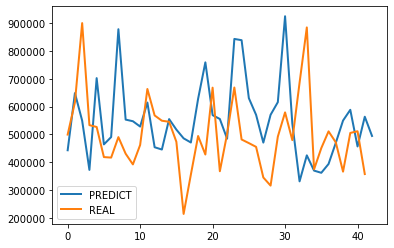

In [16]:
#顯示預測和實際結果的圖比對
from matplotlib import pyplot #畫圖的 package
pyplot.plot(denorm_pred, label='PREDICT', linewidth=2.0) #預測
pyplot.plot(d, label='REAL', linewidth=2.0) #實際
pyplot.legend()
pyplot.show()

In [17]:
#計算mape,查看誤差值(17~21)
a=d[:-1]
f=denorm_pred[:-1]

In [18]:
mae = abs(final['預測值'] - final['實際值'])


In [19]:
s=0
a=len(mae)

In [20]:
for i in range(0,a-1): 
    s+= mae[i] 
print(s)

3.37665116961279


In [21]:
s/a*100 

7.852677138634395